## Logistic Differential Equation
$$\frac{\partial f}{\partial t} = Rf(t)(1-f(t))$$

In [ ]:
! pip install torchopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.0/672.0 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 39.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from functorch import make_functional, grad, vmap, vjp, jacrev
import torchopt
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
##define the customized step function using torchopt's framework
##it does not retain or create the computational graph, using much less memory

from torchopt.update import apply_updates
from torchopt.typing import UninitializedState

def costum_step(
        optimizer,
        loss: torch.Tensor,
        params,
        inplace: bool | None = None,
    ):
        if isinstance(optimizer.optim_state, UninitializedState):
            optimizer.optim_state = optimizer.impl.init(params)

        if inplace is None:
            inplace = optimizer.inplace

        # Step parameter only
        grads = torch.autograd.grad(loss, params, create_graph=False, retain_graph=False, allow_unused=True)
        updates, optimizer.optim_state = optimizer.impl.update(
            grads,
            optimizer.optim_state,
            params=params,
            inplace=inplace,
        )
        return apply_updates(params, updates, inplace=inplace)

In [ ]:
class NNApproximator(nn.Module):
  def __init__(
      self,
      num_inputs = 1,
      num_outputs = 1,
      num_hidden = 1,
      dim_hidden = 1,
      act = nn.Tanh(),
  ):
    super().__init__()
    self.layer_in = nn.Linear(num_inputs, dim_hidden)
    self.layer_out = nn.Linear(dim_hidden, num_outputs)

    num_middle = num_hidden - 1
    self.middle_layers = nn.ModuleList(
        [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
    )
    self.act = act
    self.num_inputs = num_inputs
    self.num_outputs = num_outputs

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    out = self.act(self.layer_in(x))
    for layer in self.middle_layers:
      out = self.act(layer(out))
    return self.layer_out(out)

In [ ]:
##use functorch to make the above model functional
model = NNApproximator() ##build a model
fmodel, params = make_functional(model)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


In [ ]:
params

(Parameter containing:
 tensor([[-0.5578]], requires_grad=True),
 Parameter containing:
 tensor([-0.3008], requires_grad=True),
 Parameter containing:
 tensor([[0.9111]], requires_grad=True),
 Parameter containing:
 tensor([-0.9035], requires_grad=True))

In [ ]:
##define the functional model of the NN
## x is the input to the NN and params is the NN's parameters
def f(x: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
  x_ = x.unsqueeze(0)
  res = fmodel(params, x_).squeeze(0)
  return res

#use vmap primitive to allow efficient batching of the input
f_vmap = vmap(f, in_dims=(0, None))

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [ ]:
##define functions to compute the gradient of the NN w.r.t. the. input
dfdx = vmap(grad(f), in_dims=(0, None))
d2fdx2 = vmap(grad(grad(f)), in_dims=(0, None))

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.grad instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('grad')


In [ ]:
R = 1.0
X_BOUNDARY = 0.0 #x coordinate of the boundary
F_BOUNDARY = 0.5 #boundary value

##define the loss function
##params is the parameters of the NN, x is the colocation input to the NN
def loss_fn(params: torch.Tensor, x: torch.Tensor, alpha=1) -> torch.Tensor:
  #interior loss
  f_value = f_vmap(x, params)
  interior = dfdx(x, params) - R*f_value*(1-f_value)

  #boundary loss
  x0 = X_BOUNDARY
  f0 = F_BOUNDARY
  x_boundary = torch.tensor([x0])
  f_boundary = torch.tensor([f0])
  boundary = f_vmap(x_boundary, params) - f_boundary

  loss = nn.MSELoss()
  colocation_loss = loss(interior, torch.zeros_like(interior))
  BC_loss = loss(boundary, torch.zeros_like(boundary))
  loss_value = alpha*colocation_loss + (2-alpha)*BC_loss
  return loss_value, colocation_loss, BC_loss

In [ ]:
#define optimization configuration
batch_size = 30 ##number of colocation points sampled in each iteration
num_iter = 100 #maximum number of iterations
learning_rate = 1e-1
domain = (-5.0, 5.0) #logistic equation domain

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

##define the function that trains the model
def train_model(num_iter, params, batch_size, domain, display_every=10):
  loss_trace = []; colocation_trace = []; bc_trace = []
  for i in range(num_iter):

    # sample colocation points in the domain randomly at each iteration
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    #update the parameters using the functional API
    loss, loss_colo, loss_bc = loss_fn(params, x)
    params = costum_step(optimizer, loss, params)
    loss_trace.append(float(loss))
    colocation_trace.append(float(loss_colo))
    bc_trace.append(float(loss_bc))

    if ((i+1)%display_every == 0):
      print(f"Iteration {i} with loss {float(loss)}, colocation: {float(loss_colo)}, BC: {loss_bc}")
  return params, loss_trace, colocation_trace, bc_trace


In [ ]:
new_param, loss_trace, colo_trace, bc_trace = train_model(num_iter, params, batch_size, domain)

Iteration 9 with loss 0.17644789814949036, colocation: 0.006570720579475164, BC: 0.16987717151641846
Iteration 19 with loss 0.09169937670230865, colocation: 0.08335047215223312, BC: 0.008348904550075531
Iteration 29 with loss 0.12010529637336731, colocation: 0.11582192778587341, BC: 0.0042833685874938965
Iteration 39 with loss 0.08283942192792892, colocation: 0.06945731490850449, BC: 0.013382106088101864
Iteration 49 with loss 0.07246711850166321, colocation: 0.06226235628128052, BC: 0.010204759426414967
Iteration 59 with loss 0.07421337813138962, colocation: 0.06812820583581924, BC: 0.006085173226892948
Iteration 69 with loss 0.07715342938899994, colocation: 0.07274048775434494, BC: 0.0044129411689937115
Iteration 79 with loss 0.07590577006340027, colocation: 0.07184174656867981, BC: 0.004064020700752735
Iteration 89 with loss 0.07361990213394165, colocation: 0.06970035284757614, BC: 0.003919545561075211
Iteration 99 with loss 0.07231196016073227, colocation: 0.06797684729099274, BC: 

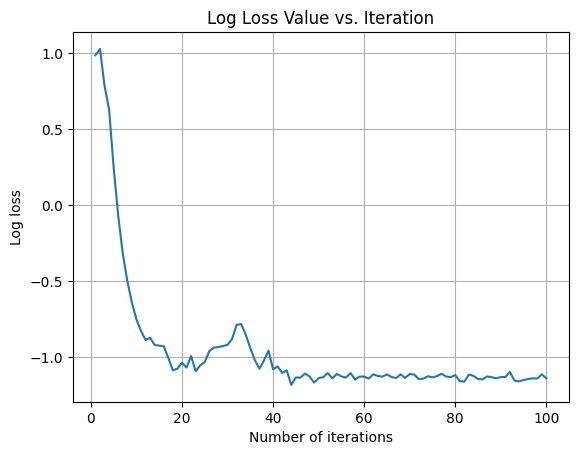

In [ ]:
##plot the loss value
plt.plot(range(1, num_iter+1), np.log10(loss_trace));
plt.xlabel("Number of iterations");
plt.ylabel("Log loss");
plt.title("Log Loss Value vs. Iteration");
plt.grid();

The analytical solution to the Logistic Equation is:

$$
f(t) = \frac{1}{Ke^{Rt} + 1}
$$

In [ ]:
def analytic_logistic(x, R, K):
  return 1/(K*np.exp(-R*x) + 1)

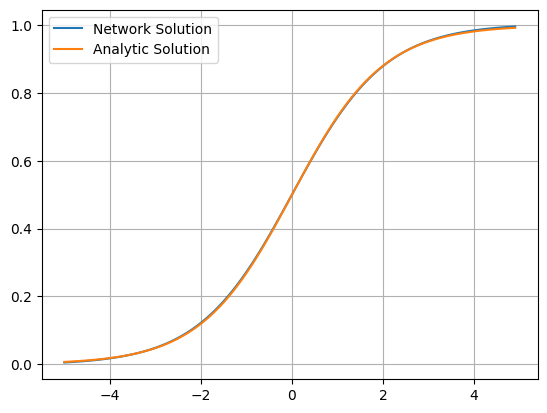

In [ ]:
##plot the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.1))
Y_NN = f_vmap(X_grid, params)
Y_analytic = analytic_logistic(X_grid, R, 1)
plt.plot(X_grid.detach().numpy(), Y_NN.detach().numpy(), label="Network Solution");
plt.plot(X_grid.detach().numpy(), Y_analytic.detach().numpy(), label="Analytic Solution");
plt.grid();
plt.legend();

Now, try to solve the following 1st order linear ODE system:

$$
\begin{cases}
  \dot{u_i} + A_i u_i = F_i \\
  u_i(0) = [x_i^{(0)}, 0]^T
\end{cases}
$$

### Network Structure
The network structure is a very simple fully connected one:

1-128-128-128-256-2

With Tanh as the activation function

In [ ]:
##this network has structure: 1 - 128 - 128 - 128 - 256 - 2
class SingleHeadNN(nn.Module):
  def __init__(self, act = nn.Tanh()):
    super().__init__()
    self.act = act
    self.linear1 = nn.Linear(1, 128)
    self.linear2 = nn.Linear(128, 128)
    self.linear3 = nn.Linear(128, 128)
    self.linear4 = nn.Linear(128, 256)
    self.linear5 = nn.Linear(256, 2)

  def forward(self, x):
    out = self.act(self.linear1(x))
    out = self.act(self.linear2(out))
    out = self.act(self.linear3(out))
    out = self.act(self.linear4(out))
    out = self.linear5(out)
    return out

In [ ]:
singlehead = SingleHeadNN()
fmodel, params = make_functional(singlehead)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


In [ ]:
def f_singlehead(x, params):
  x_ = x.unsqueeze(0)
  res = fmodel(params, x_).squeeze(0)
  return res

f_singlehead_vmap = vmap(f_singlehead, in_dims=(0, None), randomness="same")

##define gradient of the NN
dfdx_singlehead = vmap(jacrev(f_singlehead), in_dims=(0, None), randomness="same")

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')


Let's use this forcing function to test:

$$
F(t) = \begin{bmatrix}
0 \\ \gamma cos(wt)
\end{bmatrix}
$$

The matrix A is of this form:

$$
A = \begin{bmatrix}
0 & -1 \\ \alpha & \delta
\end{bmatrix}
$$

The boundary condition is of this form:

$$
u(0) = \begin{bmatrix}
 x^{(0)} \\ 0
\end{bmatrix}
$$

In [ ]:
##define the parameters for the Duffing Equation
gamma = 1; w = 1; alpha = 1; delta = 2;
A = torch.FloatTensor([[0, -1], [alpha, delta]])
##boundary condition
X_BOUNDARY = 0.0
F_BOUNDARY = 0.5

##define a forcing function
def force(x):
  return torch.stack([torch.zeros_like(x), gamma*np.cos(w*x)]).T

In [ ]:
##define the loss function
def loss_fn(params, x, A, alpha=1):
  #interior loss
  f_values = f_singlehead_vmap(x, params)
  f_gradients = dfdx_singlehead(x, params)
  Au = torch.einsum('ij,kj->ki', f_values, A).T
  forcing = force(x)
  interior = f_gradients + Au - forcing

  #boundary loss
  x_boundary = torch.tensor([X_BOUNDARY])
  f_boundary = torch.tensor([F_BOUNDARY, 0])
  boundary = f_singlehead_vmap(x_boundary, params) - f_boundary

  loss = nn.MSELoss()
  loss_colocation = loss(interior, torch.zeros_like(interior))
  loss_BC = loss(boundary, torch.zeros_like(boundary))
  loss_value = alpha*loss_colocation + (2-alpha)*loss_BC

  return loss_value, loss_colocation, loss_BC

In [ ]:
#define optimization configuration
batch_size = 30 ##number of colocation points sampled in each iteration
num_iter = 1000 #maximum number of iterations
learning_rate = 1e-3
domain = (0, 5.0) #logistic equation domain

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

##define the function that trains the model
def train_model(num_iter, params, batch_size, domain, A, alpha=1, display_every=10):
  loss_trace = []; colocation_trace = []; BC_trace = []
  for i in range(num_iter):

    # sample colocation points in the domain randomly at each iteration
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    #update the parameters using the functional API
    loss, loss_colocation, loss_BC = loss_fn(params, x, A, alpha=alpha)
    params = costum_step(optimizer, loss, params)
    loss_trace.append(float(loss))
    colocation_trace.append(float(loss_colocation))
    BC_trace.append(float(loss_BC))

    if ((i+1)%display_every == 0):
      print(f"Iteration {i} with loss {float(loss)}, colocation: {float(loss_colocation)}, BC: {loss_BC}")
  return params, loss_trace, colocation_trace, BC_trace

In [ ]:
new_params, loss_trace, colocation_trace, BC_trace = train_model(num_iter, params,
                          batch_size, domain, A, alpha=1.9, display_every=100)

Iteration 99 with loss 0.026563212275505066, colocation: 0.01289945188909769, BC: 0.020542539656162262
Iteration 199 with loss 0.01168846059590578, colocation: 0.006140428129583597, BC: 0.00021647567336913198
Iteration 299 with loss 0.005160870496183634, colocation: 0.002701838267967105, BC: 0.0002737755130510777
Iteration 399 with loss 0.0036595426499843597, colocation: 0.0019129483262076974, BC: 0.00024940905859693885
Iteration 499 with loss 0.00403476320207119, colocation: 0.0020953838247805834, BC: 0.0005353396409191191
Iteration 599 with loss 0.0024627577513456345, colocation: 0.001294276094995439, BC: 3.633146843640134e-05
Iteration 699 with loss 0.0022865277715027332, colocation: 0.0012016934342682362, BC: 3.31041264871601e-05
Iteration 799 with loss 0.0018725700210779905, colocation: 0.0009583774954080582, BC: 0.0005165278562344611
Iteration 899 with loss 0.002894503762945533, colocation: 0.0014957860112190247, BC: 0.000525103067047894
Iteration 999 with loss 0.0006780212861485

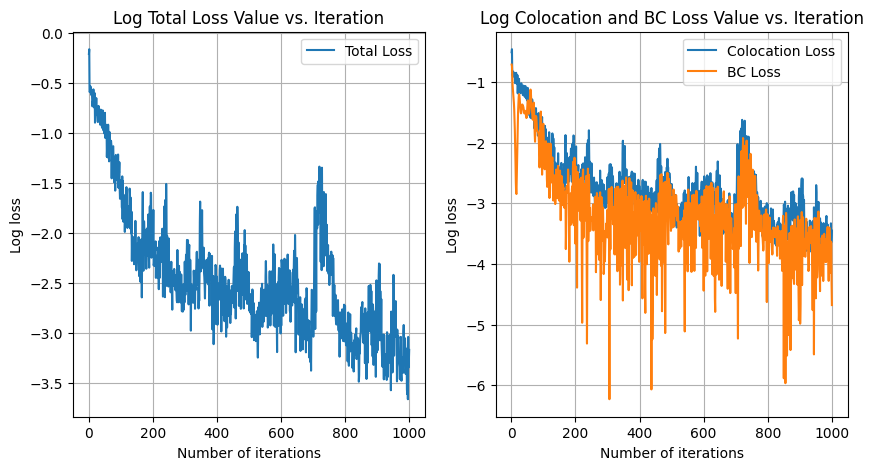

In [ ]:
##plot the loss value
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, num_iter+1), np.log10(loss_trace), label='Total Loss');
ax[1].plot(range(1, num_iter+1), np.log10(colocation_trace), label='Colocation Loss');
ax[1].plot(range(1, num_iter+1), np.log10(BC_trace), label="BC Loss");

ax[0].set_xlabel("Number of iterations");
ax[0].set_ylabel("Log loss");
ax[0].set_title("Log Total Loss Value vs. Iteration");
ax[0].grid();
ax[0].legend();
ax[1].set_xlabel("Number of iterations");
ax[1].set_ylabel("Log loss");
ax[1].set_title("Log Colocation and BC Loss Value vs. Iteration");
ax[1].grid();
ax[1].legend();

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
#get the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
Y_NN = f_singlehead_vmap(X_grid, new_params)

In [ ]:
#get the numerical solver solution
#define the RHS function
def func(t, y):
   y = np.array(y)
   A_mat = np.array([[0, -1], [alpha, delta]])
   return -A_mat@y + np.array([0, gamma*np.cos(w*t)])

numerical_result = solve_ivp(func, domain, np.array([F_BOUNDARY, 0]),
                             t_eval=np.arange(domain[0], domain[1], 0.05))

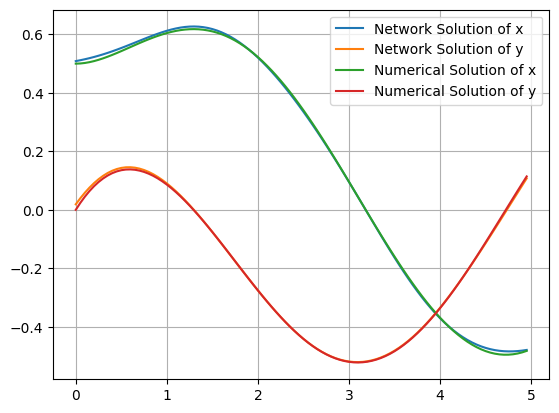

In [ ]:
##Plot the network solution
plt.plot(X_grid, Y_NN[:,0].detach().numpy(), label="Network Solution of x");
plt.plot(X_grid, Y_NN[:,1].detach().numpy(), label="Network Solution of y");
plt.plot(np.arange(domain[0], domain[1], 0.05), numerical_result.y[0], label="Numerical Solution of x");
plt.plot(np.arange(domain[0], domain[1], 0.05), numerical_result.y[1], label="Numerical Solution of y");
plt.legend();
plt.grid();

### New Network Structure

This new network structure will fit the one-shot TL:

1-256-256-256-512-(2, 256)-2

The first 4 hidden layers are fully connected. The 512 dimensional output is reshaped into H of shape (2, 256). Finally a linear layer of zero bias is applied to both components of H.

We will first try the single head approach to see it this network also works.

In [ ]:
class NNApproximator2(nn.Module):
  def __init__(self, act = nn.Tanh()):
    super().__init__()
    self.act = act
    self.linear1 = nn.Linear(1, 256)
    self.linear2 = nn.Linear(256, 256)
    self.linear3 = nn.Linear(256, 256)
    self.linear4 = nn.Linear(256, 512)
    self.final_linear = nn.Linear(256, 1, bias=False)

  def forward(self, x):
    out = self.act(self.linear1(x))
    out = self.act(self.linear2(out))
    out = self.act(self.linear3(out))
    out = self.act(self.linear4(out))
    out1 = out[:256]
    out2 = out[256:]
    out1 = self.final_linear(out1)
    out2 = self.final_linear(out2)
    return torch.cat((out1, out2))

In [ ]:
##construct a model
model = NNApproximator2()
fmodel, params = make_functional(model)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


In [ ]:
##make the model fully functional and define the jacobian function
def f2(x, params):
  x_ = x.unsqueeze(0)
  res = fmodel(params, x_).squeeze(0)
  return res

f2_vmap = vmap(f2, in_dims=(0, None), randomness="same")

##define gradient of the NN
df2dx = vmap(jacrev(f2), in_dims=(0, None), randomness="same")

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')


In [ ]:
##define the parameters for the Duffing Equation
gamma = 1; w = 1; alpha = 1; delta = 2;
A = torch.FloatTensor([[0, -1], [alpha, delta]])
##boundary condition
X_BOUNDARY = 0.0
F_BOUNDARY = 0.5

##define a forcing function
def force(x):
  return torch.stack([torch.zeros_like(x), gamma*np.cos(w*x)]).T

In [ ]:
##define the loss function
def loss_fn(params, x, A, alpha=1):
  #interior loss
  f_values = f2_vmap(x, params)
  f_gradients = df2dx(x, params)
  Au = torch.einsum('ij,kj->ki', f_values, A).T
  forcing = force(x)
  interior = f_gradients + Au - forcing

  #boundary loss
  x_boundary = torch.tensor([X_BOUNDARY])
  f_boundary = torch.tensor([F_BOUNDARY, 0])
  boundary = f2_vmap(x_boundary, params) - f_boundary

  loss = nn.MSELoss()
  loss_colocation = loss(interior, torch.zeros_like(interior))
  loss_BC = loss(boundary, torch.zeros_like(boundary))
  loss_value = alpha*loss_colocation + (2-alpha)*loss_BC

  return loss_value, loss_colocation, loss_BC

In [ ]:
#define optimization configuration
batch_size = 30 ##number of colocation points sampled in each iteration
num_iter = 1000 #maximum number of iterations
learning_rate = 1e-3
domain = (0, 5.0) #logistic equation domain

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

##define the function that trains the model
def train_model(num_iter, params, batch_size, domain, A, alpha=1, display_every=10):
  loss_trace = []; colocation_trace = []; BC_trace = []
  for i in range(num_iter):

    # sample colocation points in the domain randomly at each iteration
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    #update the parameters using the functional API
    loss, loss_colocation, loss_BC = loss_fn(params, x, A, alpha=alpha)
    params = costum_step(optimizer, loss, params)
    loss_trace.append(float(loss))
    colocation_trace.append(float(loss_colocation))
    BC_trace.append(float(loss_BC))

    if ((i+1)%display_every == 0):
      print(f"Iteration {i} with loss {float(loss)}, colocation: {float(loss_colocation)}, BC: {loss_BC}")
  return params, loss_trace, colocation_trace, BC_trace

In [ ]:
new_params, loss_trace, colocation_trace, BC_trace = train_model(num_iter, params,
                          batch_size, domain, A, alpha=1.9, display_every=100)

Iteration 99 with loss 0.0585656464099884, colocation: 0.03017466515302658, BC: 0.012337814085185528
Iteration 199 with loss 0.005895745009183884, colocation: 0.00295252981595695, BC: 0.002859382191672921
Iteration 299 with loss 0.005586274899542332, colocation: 0.00282282498665154, BC: 0.0022290763445198536
Iteration 399 with loss 0.0007253040093928576, colocation: 0.0003172169963363558, BC: 0.001225917600095272
Iteration 499 with loss 0.0005946132587268949, colocation: 0.00023776100715622306, BC: 0.0014286733930930495
Iteration 599 with loss 0.0013874733122065663, colocation: 0.0006692081806249917, BC: 0.0011597786797210574
Iteration 699 with loss 0.0036869067698717117, colocation: 0.0017988082254305482, BC: 0.002691709902137518
Iteration 799 with loss 0.0004359707818366587, colocation: 0.00021481139992829412, BC: 0.00027829137980006635
Iteration 899 with loss 0.0012301248498260975, colocation: 0.000632445327937603, BC: 0.00028478848980739713
Iteration 999 with loss 0.000440129311755

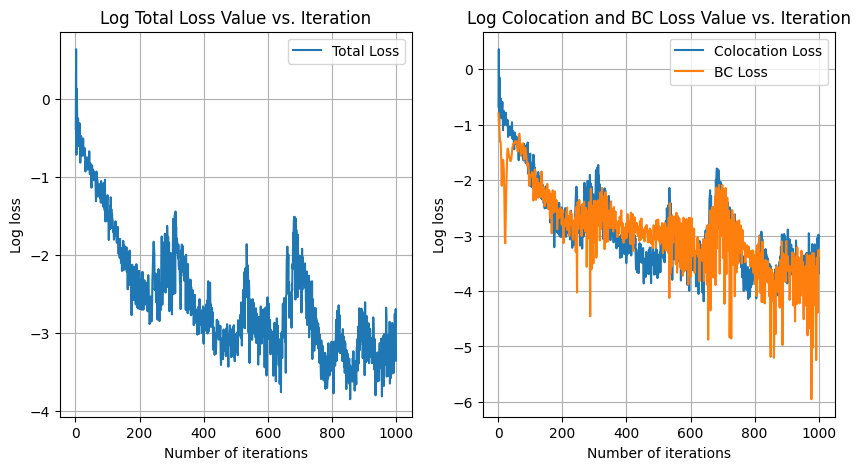

In [ ]:
##plot the loss value
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, num_iter+1), np.log10(loss_trace), label='Total Loss');
ax[1].plot(range(1, num_iter+1), np.log10(colocation_trace), label='Colocation Loss');
ax[1].plot(range(1, num_iter+1), np.log10(BC_trace), label="BC Loss");

ax[0].set_xlabel("Number of iterations");
ax[0].set_ylabel("Log loss");
ax[0].set_title("Log Total Loss Value vs. Iteration");
ax[0].grid();
ax[0].legend();
ax[1].set_xlabel("Number of iterations");
ax[1].set_ylabel("Log loss");
ax[1].set_title("Log Colocation and BC Loss Value vs. Iteration");
ax[1].grid();
ax[1].legend();

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
#get the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
Y_NN = f2_vmap(X_grid, new_params)

In [ ]:
#get the numerical solver solution
#define the RHS function
def func(t, y):
   y = np.array(y)
   A_mat = np.array([[0, -1], [alpha, delta]])
   return -A_mat@y + np.array([0, gamma*np.cos(w*t)])

numerical_result = solve_ivp(func, domain, np.array([F_BOUNDARY, 0]),
                             t_eval=np.arange(domain[0], domain[1], 0.05))

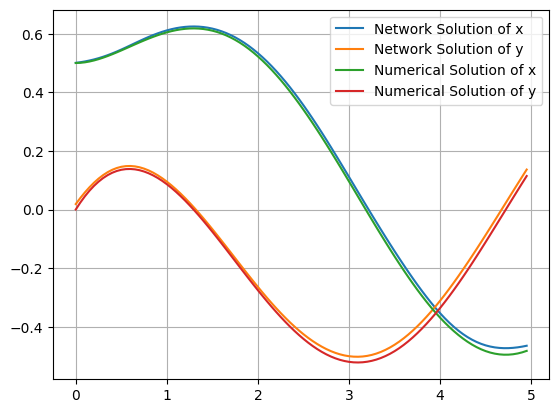

In [ ]:
##Plot the network solution
plt.plot(X_grid, Y_NN[:,0].detach().numpy(), label="Network Solution of x");
plt.plot(X_grid, Y_NN[:,1].detach().numpy(), label="Network Solution of y");
plt.plot(np.arange(domain[0], domain[1], 0.05), numerical_result.y[0], label="Numerical Solution of x");
plt.plot(np.arange(domain[0], domain[1], 0.05), numerical_result.y[1], label="Numerical Solution of y");
plt.legend();
plt.grid();

The new structure looks good, it is actually better then the previous one.


## Real Implementation
### Multiheaded Structure
Let's try to implement the multiheaded version of the above network structure.

2-256-256-256-512-(2, 257) - k heads of shape 2.

The matrix H of shape (2, 257) includes one bias column.

$H \in (2 by 257)$



In [ ]:
class Multihead(nn.Module):
  def __init__(self, k, act = nn.Tanh()):
    super().__init__()
    self.act = act
    self.linear1 = nn.Linear(1, 256)
    self.linear2 = nn.Linear(256, 256)
    self.linear3 = nn.Linear(256, 256)
    self.linear4 = nn.Linear(256, 512)
    ##define k final layers without bias
    self.final_layers = nn.ModuleList(
        ##use 257 if include the bias
        [nn.Linear(256, 1, bias=False) for _ in range(k)]
    )
    self.k = k

  #it returns the output of the network and the hidden state
  def forward(self, x):
    out = self.act(self.linear1(x))
    out = self.act(self.linear2(out))
    out = self.act(self.linear3(out))
    out = self.act(self.linear4(out))
    out1 = out[:256]
    #out1 = torch.cat((torch.Tensor([1]), out1))
    out2 = out[256:]
    #out2 = torch.cat((torch.Tensor([1]), out2))
    output = []
    for i in range(self.k):
      first = self.final_layers[i](out1)
      second = self.final_layers[i](out2)
      concat = torch.cat((first, second))
      output.append(concat)
    return torch.stack(output), out

In [ ]:
##construct a model of 10 heads
k=10
model = Multihead(k=k)
fmodel, params = make_functional(model)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


In [ ]:
model

Multihead(
  (act): Tanh()
  (linear1): Linear(in_features=1, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=512, bias=True)
  (final_layers): ModuleList(
    (0-9): 10 x Linear(in_features=256, out_features=1, bias=False)
  )
)

In [ ]:
##make the model fully functional and define the jacobian function
##this function only returns the output of the network
def f_multihead(x, params):
  x_ = x.unsqueeze(0)
  res = fmodel(params, x_)[0].squeeze(0)
  return res

#if input x contains B elements
##the output of this function will be a tensor of shape (B, k, 2)
##where k is the number of heads
f_multihead_vmap = vmap(f_multihead, in_dims=(0, None), randomness="same")

##define gradient of the NN
dfdx_multihead = vmap(jacrev(f_multihead), in_dims=(0, None), randomness="same")

##this function returns the hidden state of the network
##the hidden state depends on: 1. time 2. parameters of the network
def hidden_state(x, params):
  x_ = x.unsqueeze(0)
  H = fmodel(params, x_)[1].squeeze(0)
  return H

##returns the batched hidden states of shape (B, 512)
hidden_state_vmap = vmap(hidden_state, in_dims=(0, None), randomness="same")

#define gradient of the hidden state H'
#returns the batched gradients of the hidden states of shape (B, 512)
dHdx = vmap(jacrev(hidden_state), in_dims=(0, None), randomness="same")

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')


In [ ]:
gamma_bounds = (0.5, 3)
w_bounds = (0.5, 3)
alpha_bounds = (0.5, 4.5)
delta_bounds = (0.5, 4.5)
boundary_bounds = (-3, 3)

##this function generates k sets of parameters
##it returns a numpy array of shape (k, 4)
##and another numpy array of shape(k,) <- boundary values
def generate_parameters(k, gb = gamma_bounds,
                        wb = w_bounds, ab = alpha_bounds, db = delta_bounds,
                        bounds=boundary_bounds, seed=10):
  parameters = np.zeros((k, 4))
  boundaries = np.zeros(k)
  ##set the random seed
  np.random.seed(seed)
  for i in range(k):
    parameters[i] = [np.random.uniform(gb[0], gb[1]),
                     np.random.uniform(wb[0], wb[1]),
                     np.random.uniform(ab[0], ab[1]),
                     np.random.uniform(db[0], db[1])]
    boundaries[i] = np.random.uniform(bounds[0], bounds[1])
  return parameters, boundaries

In [ ]:
##generate the parameter set
parameter_set, F_BOUNDARIES = generate_parameters(k)

In [ ]:
##decorator to return a forcing function of form gamma*cos(w*t)
def force_decorator(gamma, w):
  def force(x):
    return torch.stack([torch.zeros_like(x), gamma*np.cos(w*x)]).T
  return force

##construct a list forcing function from the parameter set
forcing_functions = [force_decorator(p[0], p[1]) for p in parameter_set]
##construct a tensor that stores k matrice A (10, 2, 2) from the parameter set
A_matrices = torch.zeros(k, 2, 2)
for i in range(k):
  A_matrices[i] = torch.Tensor([[0.0, -1.0], [parameter_set[i][2], parameter_set[i][3]]])

##boundary condition
X_BOUNDARY = 0.0

In [ ]:
##define the loss function
def loss_fn(params, x, A_matrices, forcing_functions, alpha=1, X_BOUNDARY=0.0):
  #interior loss
  f_values = f_multihead_vmap(x, params) ##of shape (30, 10, 2)
  f_gradients = dfdx_multihead(x, params) ##of shape (30, 10, 2)
  # Expand dimensions of 'A_matrices' to match the shape of 'f_values'
  expanded_A_matrices = A_matrices.unsqueeze(0).expand(f_values.shape[0], -1, -1, -1)
  # Perform element-wise matrix multiplication using broadcasting
  Au = torch.matmul(expanded_A_matrices, f_values.unsqueeze(-1)).squeeze(-1)
  del expanded_A_matrices

  forcing = torch.stack([f(x) for f in forcing_functions]).transpose(1, 0) #shape (30, 10, 2)
  interior = f_gradients + Au - forcing #of shape (30, 10, 2)
  del f_gradients, Au, forcing

  x_boundary = torch.tensor([X_BOUNDARY])
  f_boundary = torch.stack([torch.Tensor([b, 0]) for b in F_BOUNDARIES])
  boundary = f_multihead_vmap(x_boundary, params) - f_boundary ##of shape (1, 10, 2)

  loss = nn.MSELoss()
  loss_colocation = loss(interior, torch.zeros_like(interior))
  loss_BC = loss(boundary, torch.zeros_like(boundary))
  loss_value = alpha*loss_colocation + (2-alpha)*loss_BC

  return loss_value, loss_colocation, loss_BC

In [ ]:
#define optimization configuration
batch_size = 100 ##number of colocation points sampled in each iteration
num_iter = 3000 #maximum number of iterations
learning_rate = 3e-4
domain = (0, 5.0) #logistic equation domain

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

##define the function that trains the model
def train_model(num_iter, params, batch_size, domain, A_matrices, forcing_functions,
                optimizer, alpha=1, display_every=10):
  loss_trace = []; colocation_trace = []; BC_trace = []

  for i in range(num_iter):

    # sample colocation points in the domain randomly at each iteration
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    #update the parameters using the functional API
    loss, loss_colocation, loss_BC = loss_fn(params, x, A_matrices, forcing_functions, alpha=alpha)
    params = costum_step(optimizer, loss, params)
    loss_trace.append(float(loss))
    colocation_trace.append(float(loss_colocation))
    BC_trace.append(float(loss_BC))

    if ((i+1)%display_every == 0):
      print(f"Iteration {i} with loss {float(loss)}, colocation: {float(loss_colocation)}, BC: {float(loss_BC)}")

    del loss, loss_colocation, loss_BC
  return params, loss_trace, colocation_trace, BC_trace

In [ ]:
%time
Alpha=1
new_params, loss_trace, colocation_trace, BC_trace = train_model(num_iter, params,
                          batch_size, domain, A_matrices, forcing_functions,
                                    optimizer, alpha=Alpha, display_every=100)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs
Iteration 99 with loss 0.5615392923355103, colocation: 0.5317768454551697, BC: 0.02976243756711483
Iteration 199 with loss 0.33804717659950256, colocation: 0.33545857667922974, BC: 0.0025885954964905977
Iteration 299 with loss 0.28302767872810364, colocation: 0.2826443612575531, BC: 0.00038330984534695745
Iteration 399 with loss 0.16579821705818176, colocation: 0.1653282195329666, BC: 0.0004699940327554941
Iteration 499 with loss 0.06523270159959793, colocation: 0.06458446383476257, BC: 0.0006482374155893922
Iteration 599 with loss 0.04047127440571785, colocation: 0.040287937968969345, BC: 0.00018333671323489398
Iteration 699 with loss 0.01633618399500847, colocation: 0.016254503279924393, BC: 8.16815736470744e-05
Iteration 799 with loss 0.012751494534313679, colocation: 0.012653223238885403, BC: 9.827108442550525e-05
Iteration 899 with loss 0.006010799668729305, colocation: 0.005939916707575321, BC: 7.088280108291656e-05


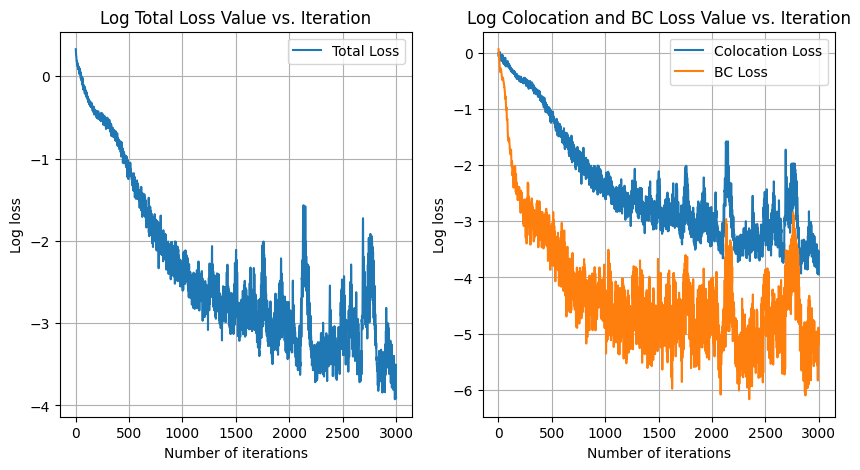

In [ ]:
##plot the loss value
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, num_iter+1), np.log10(loss_trace), label='Total Loss');
ax[1].plot(range(1, num_iter+1), np.log10(colocation_trace), label='Colocation Loss');
ax[1].plot(range(1, num_iter+1), np.log10(BC_trace), label="BC Loss");

ax[0].set_xlabel("Number of iterations");
ax[0].set_ylabel("Log loss");
ax[0].set_title("Log Total Loss Value vs. Iteration");
ax[0].grid();
ax[0].legend();
ax[1].set_xlabel("Number of iterations");
ax[1].set_ylabel("Log loss");
ax[1].set_title("Log Colocation and BC Loss Value vs. Iteration");
ax[1].grid();
ax[1].legend();

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
#get the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
Y_NN = f_multihead_vmap(X_grid, new_params) #shape (100, 10, 2)
Y_NN = Y_NN.transpose(0, 1)

In [ ]:
##get numerical solutions
#define the RHS function decorator
def RHS_decorator(gamma, w, alpha, delta):
  def func(t, y):
    y = np.array(y)
    A_mat = np.array([[0, -1], [alpha, delta]])
    return -A_mat@y + np.array([0, gamma*np.cos(w*t)])
  return func

t_eval = np.arange(domain[0], domain[1], 0.05)
##construct a list of RHS functions
RHS_functions = [RHS_decorator(p[0], p[1], p[2], p[3]) for p in parameter_set]

numerical_result = [solve_ivp(RHS_functions[i], domain,
                    np.array([F_BOUNDARIES[i], 0]), t_eval=t_eval) for i in range(k)]

### Plot the Network Solution together with the Numerical Solution

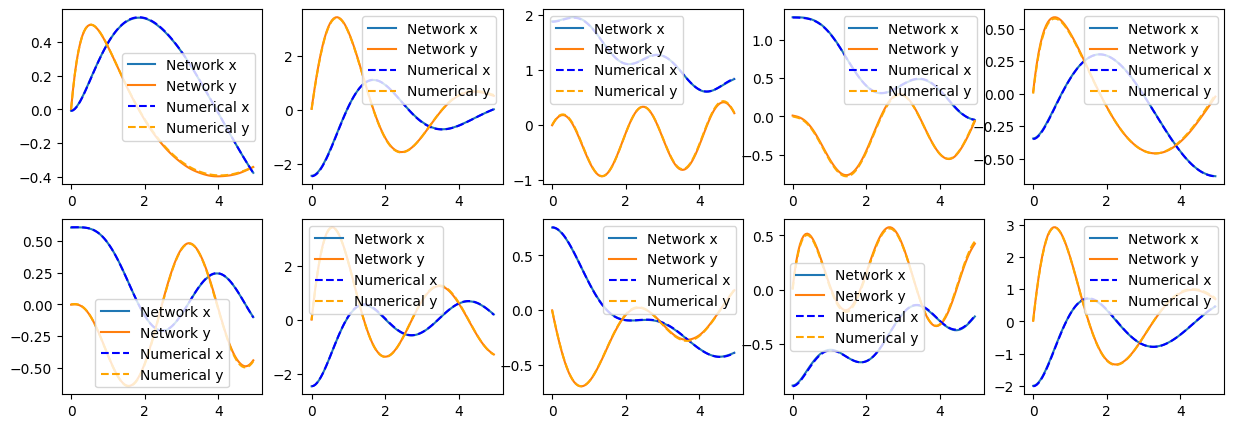

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5));
for i in range(10):
  j = i//5; l = i%5
  ax[j][l].plot(X_grid, Y_NN[i][:,0].detach().numpy(), label="Network x");
  ax[j][l].plot(X_grid, Y_NN[i][:,1].detach().numpy(), label='Network y');
  ax[j][l].plot(t_eval, numerical_result[i].y[0], '--', c='blue',label='Numerical x');
  ax[j][l].plot(t_eval, numerical_result[i].y[1], '--', c='orange',label='Numerical y');
  ax[j][l].legend();

## One-Shot Transfer Learning

In [ ]:
##this function returns the matrix M
##x is the batch of time (Tensor)
##params is the parameters of the neural network
##alpha is the parameter used in the ODE
##Alpha is the weight used in the loss function
def M_matrix(x, alpha, delta, params, Alpha=1):
  ##compute the batched Hidden states
  Hs = hidden_state_vmap(x, params).detach().numpy() #(B, 512)
  ##compute the batched gradients of the hidden states
  H_primes = dHdx(x, params).detach().numpy() #(B, 512)
  ##construct the matrix A
  A = np.array([[0.0, -1.0], [alpha, delta]])

  #compute the first part of the matrix M
  results = []
  for i in range(Hs.shape[0]):
    h = Hs[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    hp = H_primes[i].reshape(2, 256)
    #hp = np.hstack((np.zeros((hp.shape[0], 1)), hp)) ##add the bias column
    B = hp.T@A@h
    matrix = hp.T@hp + B + B.T + h.T@A.T@A@h
    results.append(matrix)
  results = np.array(results)
  results = np.mean(results, axis=0)

  #compute the second part of the matrix M
  #compute the hidden state at time 0
  h0 = hidden_state_vmap(torch.Tensor([0]), params).detach().numpy()[0].reshape(2, 256)
  #h0 = np.hstack((np.ones((h0.shape[0], 1)), h0)) ##add the bias column
  return Alpha*results + (2-Alpha)*h0.T@h0

#compute the analytic W that minimizes the loss function
#alpha is the parameter used in the ODE
#Alpha is the weight used in the loss functioon
def compute_W(x, alpha, delta, params, Minv, F, boundary_value, Alpha=1):
  h0 = hidden_state_vmap(torch.Tensor([0]), params).detach().numpy()[0].reshape(2, 256)
  #h0 = np.hstack((np.ones((h0.shape[0], 1)), h0)) ##add the bias column
  u0 = np.array([[boundary_value], [0]]) ##boundary condition

  ##compute the batched Hidden states
  Hs = hidden_state_vmap(x, params).detach().numpy()
  ##compute the batched gradients of the hidden states
  H_primes = dHdx(x, params).detach().numpy()
  ##construct the matrix A
  A = np.array([[0.0, -1.0], [alpha, delta]])

  fs = F(x) #(B, 2) shape
  if type(fs) is not np.ndarray:
    fs = fs.numpy()
  results = []
  for i in range(Hs.shape[0]):
    h = Hs[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    hp = H_primes[i].reshape(2, 256)
    #hp = np.hstack((np.zeros((hp.shape[0], 1)), hp)) ##add the bias column
    f = fs[i].reshape(2, 1)
    results.append((hp.T + h.T@A.T)@f)
  results = np.array(results)
  results = Alpha*np.mean(results, axis=0) + (2-Alpha)*h0.T@u0
  W = Minv@results
  return W

Try out the following unseen parameters:
$$
\alpha = 1, \delta = 0.5, \gamma = 1, w = 2
$$

Boundary at 0.5.

In [ ]:
##get the true numerical solution
#define the RHS function
def RHS_decorator(gamma, w, alpha, delta):
  def func(t, y):
    y = np.array(y)
    A_mat = np.array([[0, -1], [alpha, delta]])
    return -A_mat@y + np.array([0, gamma*np.cos(w*t)])
  return func

#this function gives you the solution of an unseen ODE using one-shot transfer learning
#x: tensor: batched tensors of inputs to compute the M and W
#a, d, r, omega, boundary are all parameters of the ODE
#params: is the trained network's parameters
#X_grid: the values at which we want to evaluate the network at
#returns:
#a numpy nd array of (N, 2) where N is the size of X_grid
def one_shot_TL(x, a, d, r, omega, boundary, params, X_grid, alpha=1, F = None):
  ##decorator to return a forcing function of form gamma*cos(w*t)
  def force_decorator(gamma, w):
    def force(x):
      return torch.stack([torch.zeros_like(x), gamma*np.cos(w*x)]).T
    return force
  M = M_matrix(x, a, d, params, Alpha=alpha); Minv = np.linalg.inv(M)
  #define forcing function
  if F is None:
    F = force_decorator(r, omega)
  ##compute the analytic W
  W = compute_W(x, a, d, params, Minv, F, boundary, Alpha=alpha)
  Hs = hidden_state_vmap(X_grid, params).detach().numpy()
  analytic_result = []
  for i in range(X_grid.shape[0]):
    h = Hs[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    analytic_result.append(h@W)
  analytic_result = np.array(analytic_result)
  return analytic_result, W

##this function computes the numerical solution on X_grid values
def compute_numerical_solution(a, d, r, omega, boundary, X_grid, domain):
  numerical_solution = solve_ivp(RHS_decorator(r, omega, a, d), domain, np.array([boundary, 0]),
                             t_eval=X_grid)
  return numerical_solution

In [ ]:
##get the network solution for this parameter set
a = 1; d = 0.5; r = 1; omega = 2; boundary = 0.5; Alpha=1
x = torch.FloatTensor(100).uniform_(domain[0], domain[1])
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
analytic_result, W = one_shot_TL(x, a, d, r, omega, boundary, new_params, X_grid, alpha=Alpha)
##get the numerical solution
numerical_solution = compute_numerical_solution(a, d, r, omega, boundary, X_grid, domain)

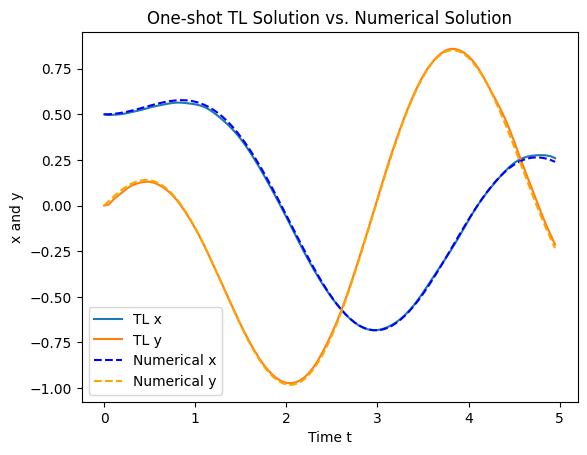

In [ ]:
plt.plot(X_grid, analytic_result[:,0], label='TL x');
plt.plot(X_grid, analytic_result[:,1], label='TL y')
plt.plot(X_grid, numerical_solution.y[0], '--', c='blue', label="Numerical x");
plt.plot(X_grid, numerical_solution.y[1], '--', c='orange', label="Numerical y");
plt.legend();
plt.xlabel("Time t");
plt.ylabel("x and y");
plt.title("One-shot TL Solution vs. Numerical Solution");

Now we need to find a way to quantatively measure the transfer-learning results. We will define the previous loss function for the TL learnt network.

In [ ]:
##this function computes the loss of the PINN after one-shot TL
def loss_TL(x, params, a, d, r, omega, W, boundary, alpha=1, F = None):
  H_prime = dHdx(x, params).detach().numpy() #B by 512
  H = hidden_state_vmap(x, params).detach().numpy() #B by 512
  A = np.array([[0.0, -1.0], [a, d]])
  if F is None:
    F = force_decorator(r, omega)
  fs = F(x)
  if type(fs) is not np.ndarray:
    fs = F(x).numpy()
  #colocation loss
  colo = []
  for i in range(H.shape[0]):
    hp = H_prime[i].reshape(2, 256)
    #hp = np.hstack((np.zeros((hp.shape[0], 1)), hp)) ##add the bias column
    h = H[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    colo.append((hp+A@h)@W - fs[i].reshape(2, 1))
  colo = np.array(colo)
  loss_colocation = (colo**2).sum()/H.shape[0]
  ##BC loss
  H0 = hidden_state_vmap(torch.Tensor([0]), params).detach().numpy()[0].reshape(2, 256)
  #H0 = np.hstack((np.ones((H0.shape[0], 1)), H0)) ##add the bias column
  u0 = H0@W
  loss_BC = ((u0 - np.array([[boundary], [0]]))**2).sum()
  return alpha*loss_colocation + (2-alpha)*loss_BC, loss_colocation, loss_BC

In [ ]:
Alpha = 1
total_loss, loss_colo, loss_BC = loss_TL(x, new_params, a, d, r, omega, W, boundary, alpha=Alpha)
print("Using alpha = {}, the loss statistics of the previous parameter set is:".format(Alpha))
print("Weighted Total Loss: {}".format(total_loss))
print("Colocation Loss: {}".format(loss_colo))
print("BC loss: {}".format(loss_BC))

Using alpha = 1, the loss statistics of the previous parameter set is:
Weighted Total Loss: 0.0005622114742102516
Colocation Loss: 0.0005622114698166836
BC loss: 4.393568121446451e-12


### Try another 10 in-distribution parameter sets

In [ ]:
##generate the parameter set
new_parameters, NEW_BOUNDARIES = generate_parameters(k, seed=108)

In [ ]:
new_solutions_TL = []
new_solutions_numerical = []
TL_Losses = [];
for i in range(10):
  a, d, r, omega = new_parameters[i]
  analytic, W = one_shot_TL(x, a, d, r, omega, NEW_BOUNDARIES[i], new_params, X_grid)
  numerical = compute_numerical_solution(a, d, r, omega, NEW_BOUNDARIES[i], X_grid, domain)
  TL_Losses.append(loss_TL(x, new_params, a, d, r, omega, W, NEW_BOUNDARIES[i], alpha=Alpha))
  new_solutions_TL.append(analytic)
  new_solutions_numerical.append(numerical)

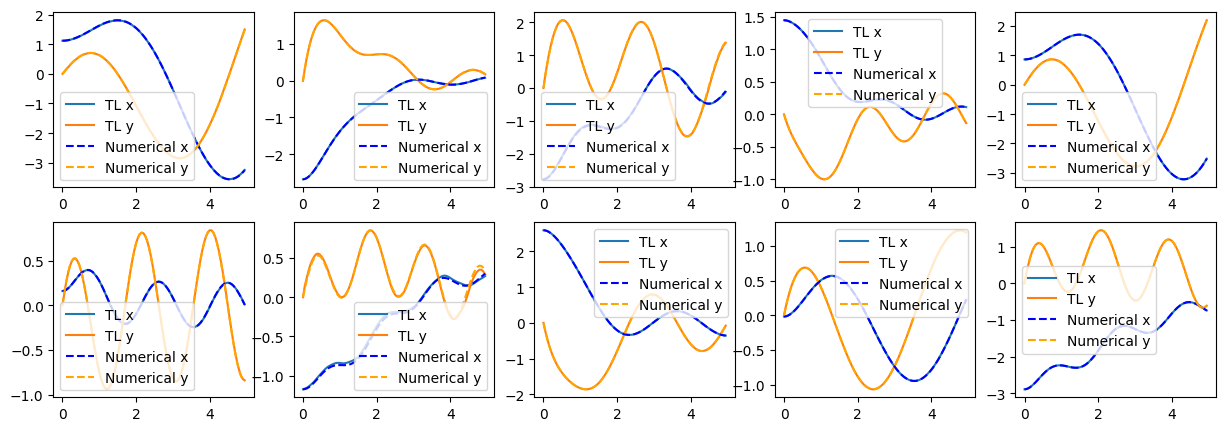

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5));
for i in range(10):
  j = i//5; l = i%5
  ax[j][l].plot(X_grid, new_solutions_TL[i][:,0], label="TL x");
  ax[j][l].plot(X_grid, new_solutions_TL[i][:,1], label='TL y');
  ax[j][l].plot(X_grid, new_solutions_numerical[i].y[0], '--', c='blue',label='Numerical x');
  ax[j][l].plot(X_grid, new_solutions_numerical[i].y[1], '--', c='orange',label='Numerical y');
  ax[j][l].legend();

In [ ]:
print("Using alpha={}, below is the loss statistics for all 10 new parameters:".format(Alpha))
for i in range(10):
  print("Parameter set #{}".format(i+1))
  print("Total Loss: {}".format(TL_Losses[i][0]))
  print("Colocation Loss: {}".format(TL_Losses[i][1]))
  print("BC Loss: {}".format(TL_Losses[i][2]))
  print("===================================")

Using alpha=1, below is the loss statistics for all 10 new parameters:
Parameter set #1
Total Loss: 0.00032396757746985913
Colocation Loss: 0.0003239674090125551
BC Loss: 1.684573040534049e-10
Parameter set #2
Total Loss: 0.00010515864333989627
Colocation Loss: 0.00010515858374329491
BC Loss: 5.959660136042591e-11
Parameter set #3
Total Loss: 0.0028385504515556956
Colocation Loss: 0.002838550151539717
BC Loss: 3.000159785611315e-10
Parameter set #4
Total Loss: 9.760510659285757e-07
Colocation Loss: 9.760452941253253e-07
BC Loss: 5.7718032503931406e-12
Parameter set #5
Total Loss: 6.459809645560146e-05
Colocation Loss: 6.459797663204389e-05
BC Loss: 1.1982355756969504e-10
Parameter set #6
Total Loss: 0.00013333359184099417
Colocation Loss: 0.00013333358349350757
BC Loss: 8.347486590299872e-12
Parameter set #7
Total Loss: 0.002074620742210483
Colocation Loss: 0.0020746207187008676
BC Loss: 2.3509615322497593e-11
Parameter set #8
Total Loss: 1.7032710768902094e-05
Colocation Loss: 1.70323

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
##save the parameters
import pickle
file = open('/content/drive/MyDrive/PINN/PINN_program/new_params_10heads.obj', 'wb')
pickle.dump(new_params, file)
file.close()